In [1]:
# working dir
import os
import sys

cwd = os.getcwd()
root_dir = os.path.dirname(os.path.dirname(cwd))
sys.path.append(root_dir)

print(root_dir)

c:\Users\david\Desktop\Main\03_Uni\WWI21DSA\02_Vorlesungen\06_Projektrealisierung\Projektrealisierung


In [2]:
# Imports and settings
import pandas as pd
import random

random.seed(42)

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [3]:
import pandas as pd
from IPython.display import display, HTML

# Display Dataframe (with scrollbars)
def ddf(df, max_height=500, max_width=1500):
    """
    Display a pandas DataFrame with horizontal and vertical scrollbars in a Jupyter notebook.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to display.
    max_height (int): The maximum height of the scrollable area in pixels.
    max_width (int): The maximum width of the scrollable area in pixels.
    """
    style = f"""
    <style>
    .scrollable-dataframe {{
        max-height: {max_height}px;
        max-width: {max_width}px;
        overflow: auto;
        display: inline-block;
        position: relative;
    }}
    .scrollable-dataframe thead th {{
        position: sticky;
        top: 0;
        background-color: white;
        z-index: 1;
    }}
    </style>
    """
    html = style + df.to_html(classes='scrollable-dataframe')
    display(HTML(html))


In [4]:
# Load data
abcd_cwata = pd.read_csv("../../src/data/extracted/abcd_CalculateWeightAndTrimAction.csv")
abcd_cwata["airline"] = "abcd"
mnop_cwata = pd.read_csv("../../src/data/extracted/mnop_CalculateWeightAndTrimAction.csv")
mnop_cwata["airline"] = "mnop"
zyxw_cwata = pd.read_csv("../../src/data/extracted/zyxw_CalculateWeightAndTrimAction.csv")
zyxw_cwata["airline"] = "zyxw"

cwata = pd.concat([abcd_cwata, mnop_cwata, zyxw_cwata])

cwata = cwata.sort_values(["airline", "flight_id", "id"], ascending=[True, True, True])

In [6]:
max_value = 150_000

removed_rows = 0
for col in ['START_WI_weight', 'DO_WI_weight', 'PAX_WI_weight',
       'TOTAL_DEADLOAD_WI_weight', 'TOTAL_LOAD_WI', 'TOTAL_TRAFFIC_LOAD',
       'AZFW', 'ATOW', 'ALAW', 'ATXW', 'ALLOWED_TOW', 'ALLOWED_ZFW',
       'ALLOWED_LAW', 'ALLOWED_TXW', 'UNDERLOAD', 'ESTIMATED_TRAFFIC_LOAD',
       'ESTIMATED_ZFW', 'DELTA_ZFW']:
    
    lcwata = len(cwata)
    cwata = cwata[cwata[col] <= max_value]
    removed_rows += lcwata - len(cwata)


for col1, col2 in [("ATOW", "ALLOWED_TOW"), ("ALAW", "ALLOWED_LAW")]:
    lcwata = len(cwata)
    cwata = cwata[cwata[col1] <= cwata[col2]]
    removed_rows += lcwata - len(cwata)


print("removed rows:", removed_rows)

removed rows: 363


In [7]:
abcd_flight_ids = set(abcd_cwata["flight_id"])
mnop_flight_ids = set(mnop_cwata["flight_id"])
zyxw_flight_ids = set(zyxw_cwata["flight_id"])

abcd_flight_ids.intersection(mnop_flight_ids), abcd_flight_ids.intersection(zyxw_flight_ids), mnop_flight_ids.intersection(zyxw_flight_ids)

(set(), set(), set())

In [8]:
# def split_creation_time(df):
#     df["creation_time"] = pd.to_datetime(df["creation_time"])
#     df["creation_date"] = df["creation_time"].dt.date
#     df["creation_time"] = df["creation_time"].dt.time
#     start_cols = ["id", "creation_date", "creation_time"]
#     df = df[start_cols + [col for col in df.columns if col not in start_cols]]
#     return df

In [9]:
# abcd_cols = ['id', "flight_id", 'creation_time', 'airline_code', 'flight_number', 'flight_date', 'departure_airport']
# abcd_filtered = abcd[abcd_cols]

cwata_cols = ["id", "flight_id", "AZFW", "ESTIMATED_ZFW"]
cwata_filtered = cwata[cwata_cols]
df = cwata_filtered
# df = cwata_filtered.merge(abcd_filtered, left_on="id", right_on="id", how="left")
# df = df[abcd_cols + [col for col in df.columns if col not in abcd_cols]]

# df = split_creation_time(df)
df = df.dropna()


In [10]:
flight_ids = df["flight_id"].unique()

In [11]:
azfw_all = df.groupby('flight_id')['AZFW'].last()
azfw_all = azfw_all.reset_index()

[('AB_2541_7_CCU', 'AB_2565_4_CCU', 'AB_2349_1_BOM'), ('MN_1182_2_DUB', 'MN_1524_2_DUB', 'MN_1586_8_DUB'), ('ZY_5546_30_VCP', 'ZY_3805_3_VCP', 'ZY_113_3_FOR')]


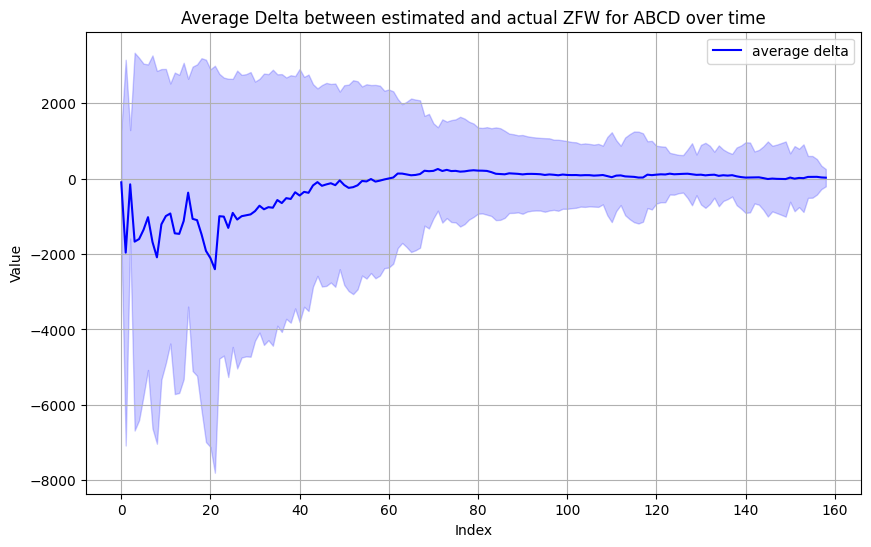

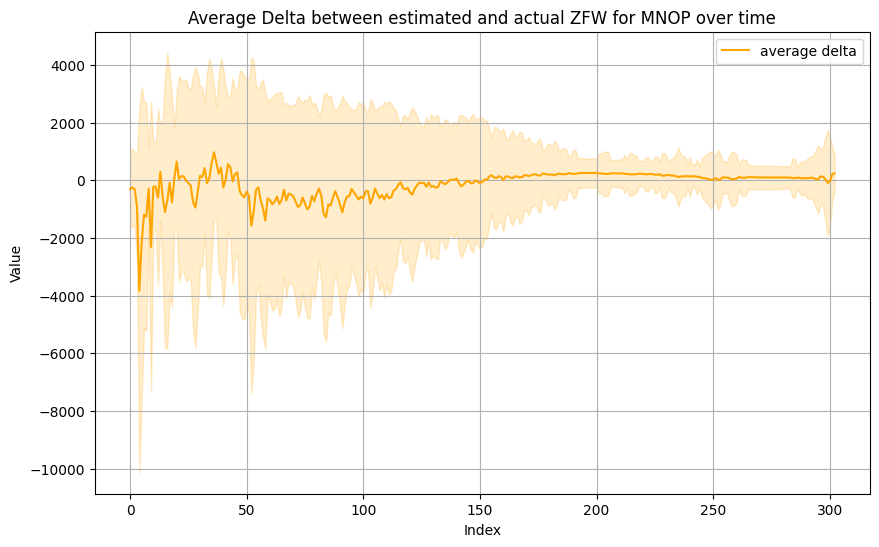

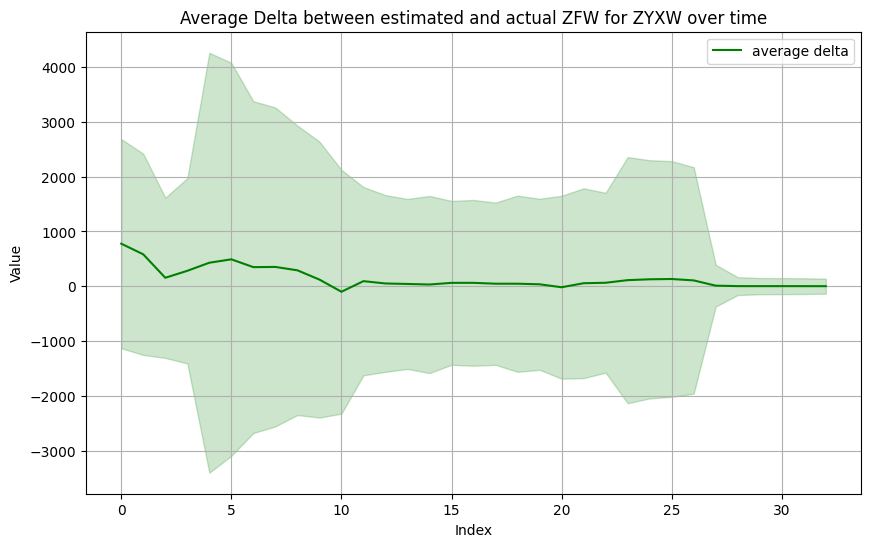

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Group by flight_id and calculate deltas
grouped = df.groupby("flight_id")

deltas = {}
for flight_id, group in grouped:
    estimations = np.array(group["ESTIMATED_ZFW"].to_list())
    actual = azfw_all[azfw_all["flight_id"] == flight_id]["AZFW"].values[0]
    deltas[flight_id] = estimations - actual

def plot_dict(data_dict, title, color):
    """
    Creates a line plot from a dictionary where each key is the label
    and each value is a tuple containing the average data points and standard deviation.

    Parameters:
    data_dict (dict): Dictionary with labels as keys and tuples of lists (average, std) as values.
    """
    plt.figure(figsize=(10, 6))

    for label, (avg_data_points, std_data_points) in data_dict.items():
        plt.plot(avg_data_points, label=label, color=color)
        plt.fill_between(range(len(avg_data_points)), 
                         np.array(avg_data_points) - np.array(std_data_points), 
                         np.array(avg_data_points) + np.array(std_data_points), 
                         color=color, alpha=0.2)

    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Unique flight IDs for each airline
abcd_flights = cwata[cwata["airline"] == "abcd"]["flight_id"].unique()
mnop_flights = cwata[cwata["airline"] == "mnop"]["flight_id"].unique()
zyxw_flights = cwata[cwata["airline"] == "zyxw"]["flight_id"].unique()

interesting_flights = []

for airline_code, flights in [("abcd", abcd_flights), ("mnop", mnop_flights), ("zyxw", zyxw_flights)]:
    # Filter deltas for the current airline's flights
    deltas_filtered = {k: v for k, v in deltas.items() if k in flights}
    
    # Determine the longest delta and number of flights
    longest_delta = max([len(v) for v in deltas_filtered.values()])
    num_flights = len(deltas_filtered)
    
    # Create a dataset of deltas
    dataset_deltas = np.zeros((longest_delta, num_flights))
    for i in range(1, longest_delta + 1):
        for j, v in enumerate(deltas_filtered.values()):
            if i <= len(v):
                dataset_deltas[-i, j] = v[-i]
            else:
                dataset_deltas[-i, j] = np.nan
    
    # Calculate total deviation for each flight
    total_deviations = np.nansum(dataset_deltas, axis=0)
    
    # Find the flight IDs with the greatest, lowest, and average deviation
    max_dev_flight = list(deltas_filtered.keys())[np.nanargmax(total_deviations)]
    min_dev_flight = list(deltas_filtered.keys())[np.nanargmin(total_deviations)]
    avg_dev = np.nanmean(total_deviations)
    avg_dev_flight = min(deltas_filtered.keys(), key=lambda k: abs(total_deviations[list(deltas_filtered.keys()).index(k)] - avg_dev))
    
    # Append the results to interesting_flights
    interesting_flights.append((max_dev_flight, min_dev_flight, avg_dev_flight))

print(interesting_flights)

# Plotting average delta with standard deviation
for airline_code, color, flights in [("abcd", "blue", abcd_flights), ("mnop", "orange", mnop_flights), ("zyxw", "green", zyxw_flights)]:
    deltas_filtered = {k: v for k, v in deltas.items() if k in flights}
    
    longest_delta = max([len(v) for v in deltas_filtered.values()])

    average_delta = []
    std_delta = []
    for i in range(1, longest_delta + 1):
        timestep = [v[-i] for v in deltas_filtered.values() if i < len(v)]
        if len(timestep) >= 10:
            average_delta.insert(0, np.mean(timestep))
            std_delta.insert(0, np.std(timestep))
    
    title = f"Average Delta between estimated and actual ZFW for {airline_code.upper()} over time"
    plot_dict({"average delta": (average_delta, std_delta)}, title, color)
